# DCC-GARCH(1,1) model
- The parameters of individual GARCH and DCC-GARCH are reasonable 

- Strong correlations between residuals (not good)

In [1]:
from IPython.display import display

import yfinance as yf
import pandas as pd
import numpy as np
import time

# Step 1: Hardcode the list of famous US ETFs
etf_tickers = [
    "SPY",   # Broad market: S&P 500
    "QQQ",   # Broad market: Nasdaq-100
    "VTI",   # Broad market: Total US stock
    "IWM",   # Small-cap: Russell 2000
    "XLK",   # Sector: Technology
    "XLV",   # Sector: Healthcare
    "XLF",   # Sector: Financials
    "XLE",   # Sector: Energy
    "XLI",   # Sector: Industrials
    "XLY",   # Sector: Consumer Discretionary
    "XLP",   # Sector: Consumer Staples
    "XLB",   # Sector: Materials
    "XLRE",  # Sector: Real Estate
    "XLU",   # Sector: Utilities
    "GLD",   # Commodity: Gold
    "USO",   # Commodity: Oil
    "TLT",   # Bond: 20+ Year Treasuries
    "LQD",   # Bond: Corporate bonds
    "EEM",   # Emerging markets
    "VXUS"   # International ex-US
]
etf_tickers = ["SPY", "QQQ", "VTI", "XLK", "XLY"]  # Equity-focused subset

df = yf.download(etf_tickers, period="max", interval="1d", auto_adjust=False)["Adj Close"]
# df = yf.download(etf_tickers, start="2021-01-01", end="2024-12-31", interval="1d", auto_adjust=False)["Adj Close"]
returns = df.pct_change().dropna()
print(len(returns))

[*********************100%***********************]  5 of 5 completed

5983


In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import yfinance as yf
from IPython.display import display
import time
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from arch import arch_model
import seaborn as sns
from scipy.stats import t

class DCC_GARCH:
    def __init__(self, returns):
        """Initialize DCC_GARCH with a DataFrame of asset returns."""
        self.index = returns.index
        self.returns = returns.values
        self.tickers = returns.columns
        self.n_assets = self.returns.shape[1]
        self.n_obs = self.returns.shape[0]
        self.garch_params = None
        self.dcc_params = None
        self.volatilities = None
        self.correlations = None
        self.residuals = None


    def fit_garch(self, ticker_idx):
        """Fit GARCH(1,1) to a single asset's returns."""
        returns = self.returns[:, ticker_idx]
        model = arch_model(returns, vol="Garch", p=1, q=1, rescale=True, dist="t", mean="Zero")
        res = model.fit(disp="off")
        res.params["omega"] /= (res.scale)**2
        return res
        # [res.params["omega"], res.params["alpha[1]"], res.params["beta[1]"]]


    def compute_volatility(self, returns, params):  # not in use anymore
        """Compute time-varying volatility from GARCH parameters."""
        omega, alpha, beta = params
        variance = np.zeros_like(returns)
        variance[0] = np.var(returns)
        for t in range(1, len(returns)):
            variance[t] = omega + alpha * returns[t-1]**2 + beta * variance[t-1]
        return np.sqrt(variance)


    def fit_dcc(self, residuals):
        """Fit DCC parameters to standardized residuals."""
        def dcc_log_likelihood(params, residuals):
            a, b = params
            if a < 0 or b < 0 or a + b >= 1:
                return np.inf
            n_obs, n_assets = residuals.shape
            Q_bar = np.cov(residuals.T)  # Unconditional covariance
            Qt = np.zeros((n_obs, n_assets, n_assets))
            Rt = np.zeros((n_obs, n_assets, n_assets))
            # print(Qt.shape, n_obs, n_assets)
            Qt[0] = Q_bar  # Initial Qt
            log_likelihood = 0
            for t in range(1, n_obs):
                Qt[t] = (1 - a - b) * Q_bar + a * np.outer(residuals[t-1], residuals[t-1]) + b * Qt[t-1]
                diag_sqrt = np.sqrt(np.diag(Qt[t]))
                Rt[t] = Qt[t] / np.outer(diag_sqrt, diag_sqrt)
                # Avoid singular matrices with small regularization
                Rt[t] += np.eye(n_assets) * 1e-4
                try:
                    chol = np.linalg.cholesky(Rt[t])  # Ensure positive definiteness
                    log_likelihood -= 0.5 * (np.log(np.linalg.det(Rt[t])) + 
                                            residuals[t].T @ np.linalg.inv(Rt[t]) @ residuals[t])
                except np.linalg.LinAlgError:
                    return np.inf  # Penalize if matrix is singular
            return -log_likelihood
        
        initial_guesses = [[0.01, 0.95], [0.05, 0.9], [0.02, 0.93]]
        bounds = [(1e-6, 0.2), (0.7, 0.95)]  # Tighter, realistic ranges
        best_result = None
        best_ll = np.inf
        for init in initial_guesses:
            result = minimize(dcc_log_likelihood, init, args=(residuals,), 
                            method="SLSQP", bounds=bounds, options={"ftol": 1e-8, "maxiter": 2000})
            if result.fun < best_ll:
                best_ll = result.fun
                best_result = result
        print(f"DCC Fit Success: {best_result.success}, Message: {best_result.message}")
        return best_result.x


    def fit(self):
        """Fit the full DCC-GARCH model."""
        print("Fitting GARCH models...")
        self.garch_params = []
        self.volatilities = np.zeros_like(self.returns)
        self.residuals = np.zeros_like(self.returns)
        for i in range(self.n_assets):
            res = self.fit_garch(i)
            params = [res.params["omega"], res.params["alpha[1]"], res.params["beta[1]"]]
            self.garch_params.append(params)
            # self.volatilities[:, i] = res.conditional_volatility  # Use arch’s volatility
            # self.residuals[:, i] = res.resid / res.conditional_volatility  # Standardized residuals
            self.volatilities[:, i] = res.conditional_volatility / res.scale
            self.residuals[:, i] = res.resid / res.conditional_volatility

        print("Fitting DCC model...")
        self.dcc_params = self.fit_dcc(self.residuals)
        a, b = self.dcc_params
        Q_bar = np.cov(self.residuals.T)
        self.correlations = np.zeros((self.n_obs, self.n_assets, self.n_assets))
        Qt = np.zeros_like(self.correlations)
        Qt[0] = Q_bar
        for t in range(1, self.n_obs):
            Qt[t] = (1 - a - b) * Q_bar + a * np.outer(self.residuals[t-1], self.residuals[t-1]) + b * Qt[t-1]
            diag_sqrt = np.sqrt(np.diag(Qt[t]))
            self.correlations[t] = Qt[t] / np.outer(diag_sqrt, diag_sqrt)
            # Ensure positive definiteness
            self.correlations[t] += np.eye(self.n_assets) * 1e-6
        

    def get_volatilities(self): 
        """Return time-varying volatilities as a DataFrame."""
        if self.volatilities is None:
            raise ValueError("Model not fitted yet. Call fit() first.")
        return pd.DataFrame(self.volatilities, index=self.index, columns=self.tickers)


    def get_correlations(self):
        """Return time-varying correlation matrices as a list of DataFrames."""
        if self.correlations is None:
            raise ValueError("Model not fitted yet. Call fit() first.")
        return [pd.DataFrame(self.correlations[t], index=self.tickers, columns=self.tickers) 
                for t in range(self.n_obs)]
        
        
    def diagnostics(self):
        """Perform diagnostic checks on the model fit."""
        if self.residuals is None:
            raise ValueError("Model not fitted yet. Call fit() first.")

        print("=== Residual Sanity Check ===")
        print(f"Residuals shape: {self.residuals.shape}")
        print(f"Sample residuals (first 5 rows):")
        display(pd.DataFrame(self.residuals[:5], columns=self.tickers))

        print("=== Univariate GARCH Diagnostics ===")
        for i, ticker in enumerate(self.tickers):
            res = self.residuals[:, i]
            mean_res = np.mean(res)
            var_res = np.var(res)
            lb_test = acorr_ljungbox(res, lags=[10], return_df=True)
            lb_test_sq = acorr_ljungbox(res**2, lags=[10], return_df=True)
            print(f"\n{ticker}:")
            print(f"Mean of residuals: {mean_res:.4f} (should be ~0)")
            print(f"Variance of residuals: {var_res:.4f} (should be ~1)")
            print(f"Ljung-Box test (residuals, lag 10): p-value = {lb_test['lb_pvalue'].iloc[0]:.4f}")
            print(f"Ljung-Box test (squared residuals, lag 10): p-value = {lb_test_sq['lb_pvalue'].iloc[0]:.4f}")
            print(f"omega = {self.garch_params[i][0]:.6f}, alpha = {self.garch_params[i][1]:.4f}, beta = {self.garch_params[i][2]:.4f}")
            

        print("\n=== DCC Correlation Diagnostics ===")
        print("DCC Parameters [a, b]:", self.dcc_params)
        # Create a matrix for p-values
        n_assets = self.n_assets
        p_value_matrix = np.ones((n_assets, n_assets))  # Default to 1 (no significance)
        for i in range(n_assets):
            for j in range(i + 1, n_assets):
                cross_prod = self.residuals[:, i] * self.residuals[:, j]
                lb_cross = acorr_ljungbox(cross_prod, lags=[10], return_df=True)
                p_val = lb_cross['lb_pvalue'].iloc[0]
                p_value_matrix[i, j] = p_val
                p_value_matrix[j, i] = p_val  # Symmetric matrix
                if p_val < 0.05:
                    print(f"Significant residual cross-correlation between {self.tickers[i]} and {self.tickers[j]}: "f"p-value = {p_val:.4f}")
        # Heatmap of p-values
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            p_value_matrix,
            annot=True,  # Show p-values in cells
            fmt=".4f",   # 4 decimal places
            cmap="RdYlGn",  # Red (low p) to Green (high p), reversed
            vmin=0, vmax=1,  # p-value range
            xticklabels=self.tickers,
            yticklabels=self.tickers,
            square=True
        )
        plt.title("DCC Residual Cross-Correlation P-Values (Lag 10)")
        plt.show()
        
        print("\n=== Average Correlation Matrix ===")
        avg_corr = np.mean([self.correlations[t] for t in range(self.n_obs)], axis=0)
        display(pd.DataFrame(avg_corr, index=self.tickers, columns=self.tickers).round(4))


    def plot_diagnostics(self, ticker_idx=0):
        """Plot diagnostics for a specific asset, including histogram of standardized residuals."""
        ticker = self.tickers[ticker_idx]
        res = self.residuals[:, ticker_idx]
        vols = self.volatilities[:, ticker_idx]
        rets = self.returns[:, ticker_idx]

        # Fit t-distribution to residuals
        df, loc, scale = t.fit(res)  # Degrees of freedom, location (mean), scale (std)
        
        plt.figure(figsize=(12, 10))  # Increased height for 4 subplots

        # Subplot 1: Returns vs. Fitted Volatility
        plt.subplot(4, 1, 1)
        plt.plot(self.index, rets, label="Returns")
        plt.plot(self.index, vols, label="Fitted Volatility", color="orange")
        plt.fill_between(self.index, -vols, vols, color="orange", alpha=0.2, label="Volatility Band")
        plt.title(f"{ticker}: Returns vs. Fitted Volatility")
        plt.legend()

        # Subplot 2: Standardized Residuals Time Series
        plt.subplot(4, 1, 2)
        plt.plot(self.index, res, label="Standardized Residuals")
        plt.axhline(0, color="black", linestyle="--")
        plt.axhline(2, color="red", linestyle="--", alpha=0.5)
        plt.axhline(-2, color="red", linestyle="--", alpha=0.5)
        plt.title(f"{ticker}: Standardized Residuals")
        plt.legend()

        # Subplot 3: ACF of Squared Residuals
        plt.subplot(4, 1, 3)
        pd.plotting.autocorrelation_plot(res**2)
        plt.xlim(0, 50)
        plt.title(f"{ticker}: ACF of Squared Residuals")

        # Subplot 4: Histogram of Standardized Residuals
        plt.subplot(4, 1, 4)
        plt.hist(res, bins=50, density=True, alpha=0.7, color="blue", label="Residuals")
        x = np.linspace(min(res), max(res), 100)
        plt.plot(x, t.pdf(x, df, loc, scale), "r-", lw=2, label=f"t-dist (df={df:.1f})")
        plt.axvline(0, color="black", linestyle="--")
        plt.title(f"{ticker}: Histogram of Standardized Residuals")
        plt.legend()

        plt.tight_layout()
        plt.show()

Starting DCC-GARCH fitting...
Fitting GARCH models...
Fitting DCC model...
DCC Fit Success: True, Message: Optimization terminated successfully
DCC-GARCH fitting completed in 30.90 seconds.
=== Residual Sanity Check ===
Residuals shape: (5983, 5)
Sample residuals (first 5 rows):


Ticker,QQQ,SPY,VTI,XLK,XLY
0,-0.595963,-0.473284,-0.634589,-1.175597,0.753861
1,-0.229816,0.446561,0.287739,0.179718,0.236479
2,1.095092,0.561799,1.139806,0.506426,1.099793
3,0.648345,1.259279,0.848738,0.942508,1.339108
4,-0.113471,-0.835122,-0.681311,-0.474629,-0.708150


=== Univariate GARCH Diagnostics ===

QQQ:
Mean of residuals: 0.0480 (should be ~0)
Variance of residuals: 0.9920 (should be ~1)
Ljung-Box test (residuals, lag 10): p-value = 0.2669
Ljung-Box test (squared residuals, lag 10): p-value = 0.2365
omega = 0.000002, alpha = 0.0926, beta = 0.9014

SPY:
Mean of residuals: 0.0417 (should be ~0)
Variance of residuals: 0.9950 (should be ~1)
Ljung-Box test (residuals, lag 10): p-value = 0.0714
Ljung-Box test (squared residuals, lag 10): p-value = 0.3097
omega = 0.000002, alpha = 0.1199, beta = 0.8735

VTI:
Mean of residuals: 0.0416 (should be ~0)
Variance of residuals: 0.9962 (should be ~1)
Ljung-Box test (residuals, lag 10): p-value = 0.2649
Ljung-Box test (squared residuals, lag 10): p-value = 0.1942
omega = 0.000002, alpha = 0.1150, beta = 0.8767

XLK:
Mean of residuals: 0.0446 (should be ~0)
Variance of residuals: 0.9946 (should be ~1)
Ljung-Box test (residuals, lag 10): p-value = 0.2296
Ljung-Box test (squared residuals, lag 10): p-value = 0.

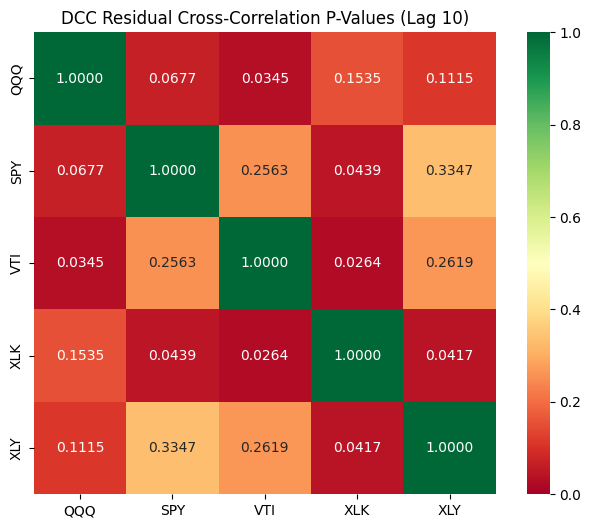


=== Average Correlation Matrix ===


Ticker,QQQ,SPY,VTI,XLK,XLY
Ticker,,,,,
QQQ,0.9998,0.8969,0.8970,0.9531,0.8246
SPY,0.8969,0.9998,0.9877,0.8845,0.8707
VTI,0.8970,0.9877,0.9998,0.8828,0.8795
XLK,0.9531,0.8845,0.8828,0.9998,0.7781
XLY,0.8246,0.8707,0.8795,0.7781,0.9998


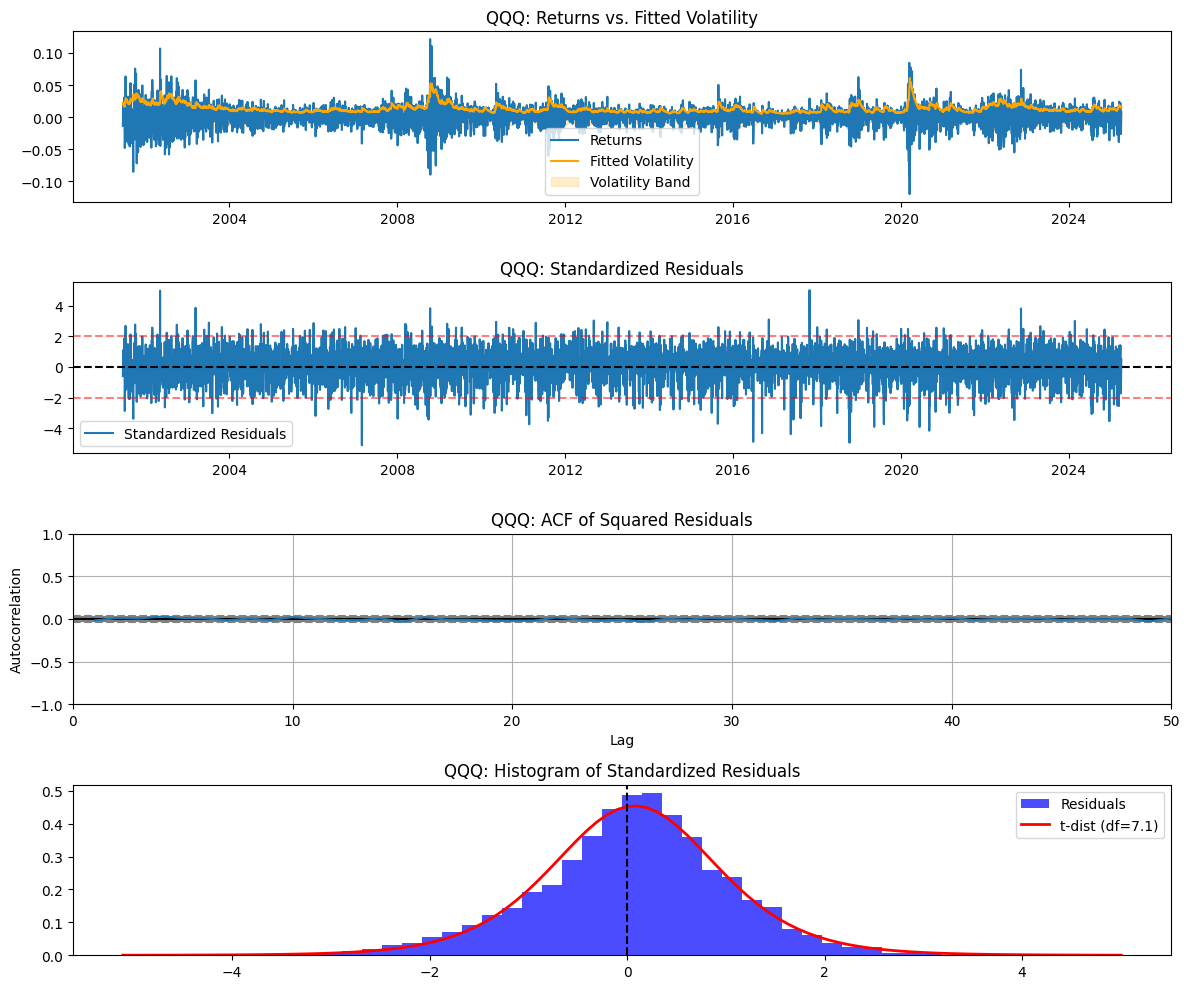

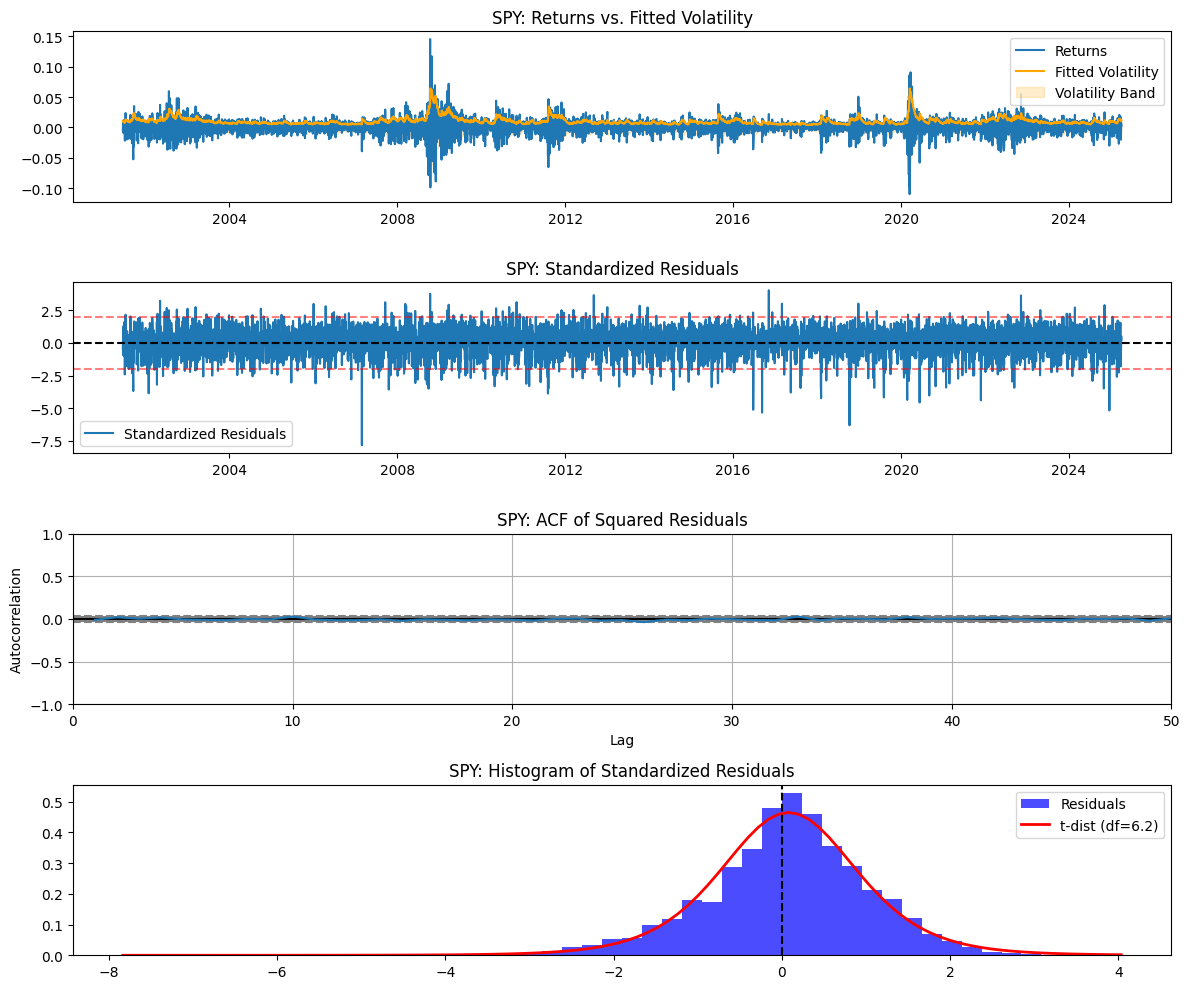

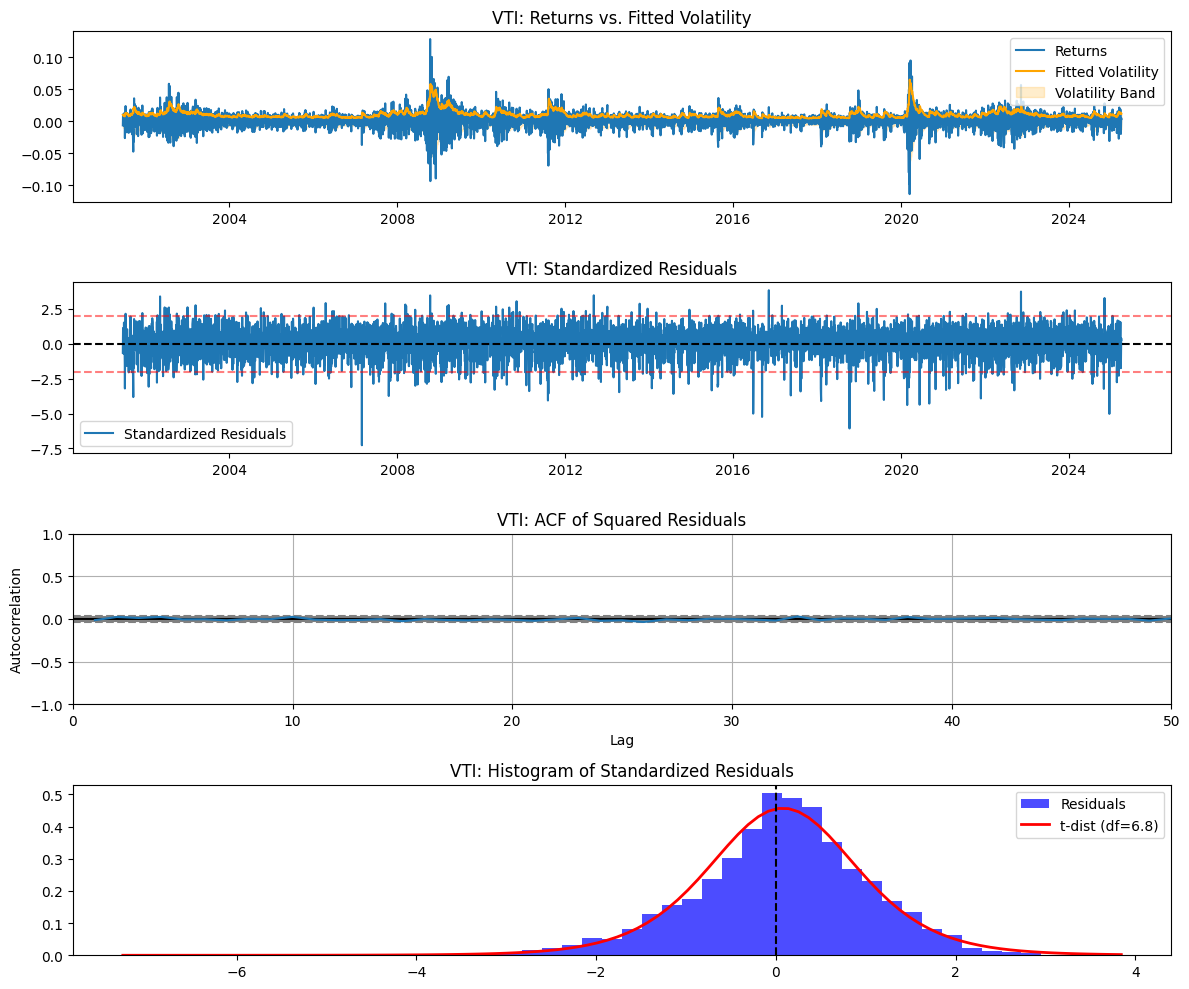

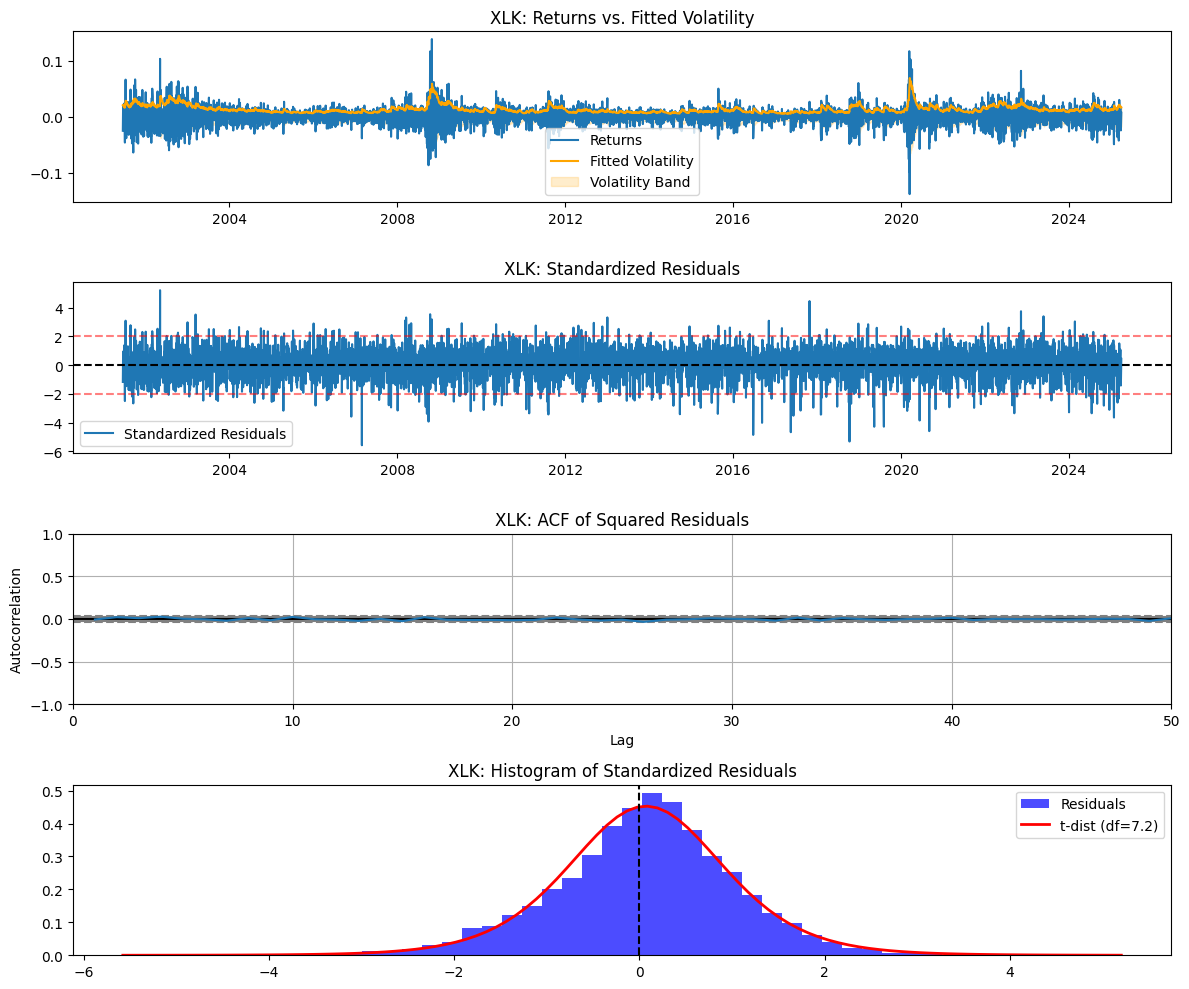

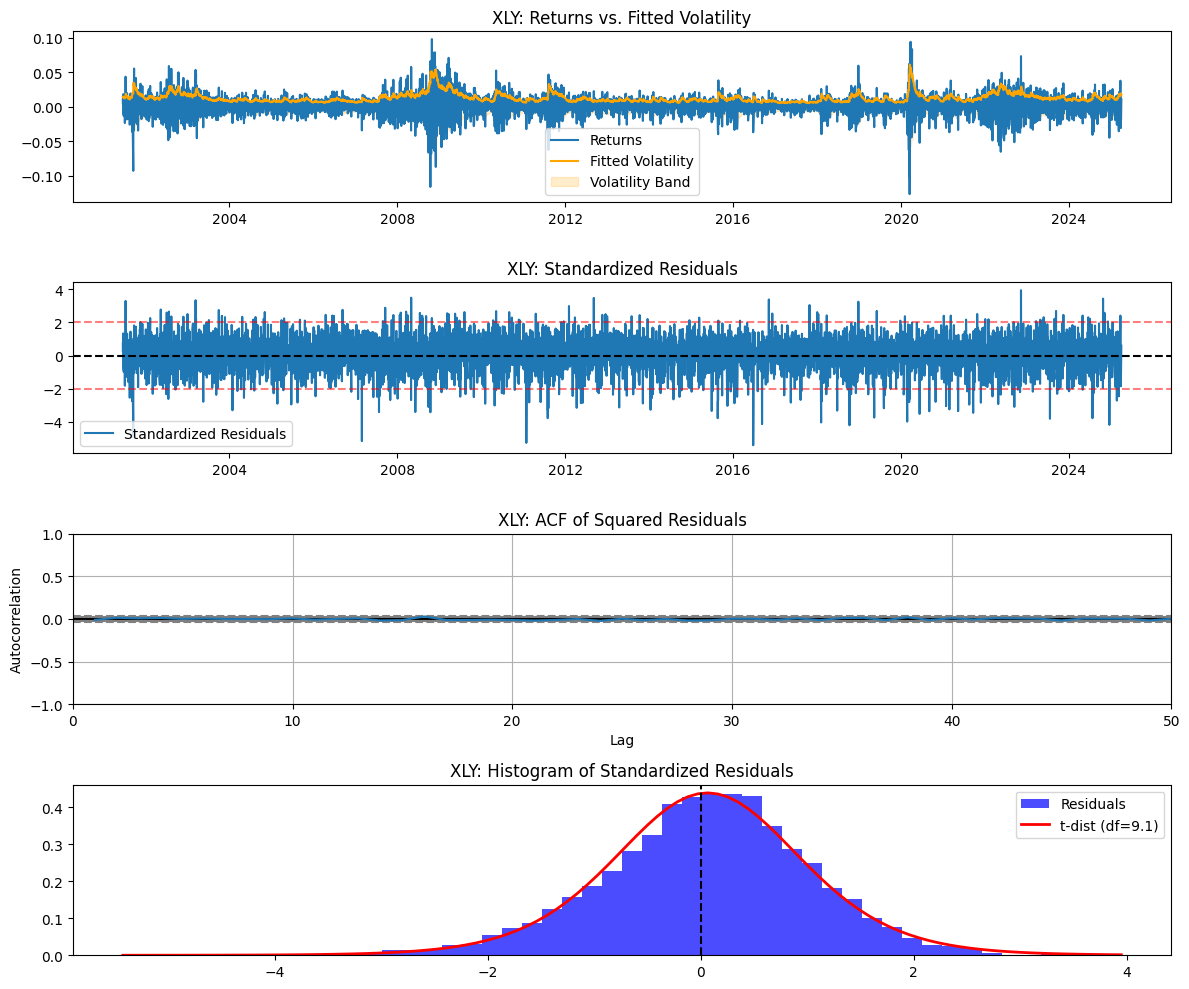

In [3]:
# Example usage

# Fit the model and time it
print("Starting DCC-GARCH fitting...")
start_time = time.time()
dcc_garch = DCC_GARCH(returns)
dcc_garch.fit()
end_time = time.time()

print(f"DCC-GARCH fitting completed in {end_time - start_time:.2f} seconds.")


# Run diagnostics
dcc_garch.diagnostics()
for i in range(len(etf_tickers)):
    dcc_garch.plot_diagnostics(ticker_idx=i)


# Display results
vols = dcc_garch.get_volatilities()
# print("Volatility Summary:")
# print(vols.describe())
corrs = dcc_garch.get_correlations()
# print("\nLast day's volatilities:")
# display(vols.iloc[-1])
# print("\nLast day's correlation matrix:")
# display(corrs[-1])

# ADCC-GARCH model
- Didn't solve the correlated residuals issue
- New parameter $g$ seems not necessary
- Performance is similar to DCC-GARCH

In [4]:
from IPython.display import display

import yfinance as yf
import pandas as pd
import numpy as np
import time

# Step 1: Hardcode the list of famous US ETFs
etf_tickers = [
    "SPY",   # Broad market: S&P 500
    "QQQ",   # Broad market: Nasdaq-100
    "VTI",   # Broad market: Total US stock
    "IWM",   # Small-cap: Russell 2000
    "XLK",   # Sector: Technology
    "XLV",   # Sector: Healthcare
    "XLF",   # Sector: Financials
    "XLE",   # Sector: Energy
    "XLI",   # Sector: Industrials
    "XLY",   # Sector: Consumer Discretionary
    "XLP",   # Sector: Consumer Staples
    "XLB",   # Sector: Materials
    "XLRE",  # Sector: Real Estate
    "XLU",   # Sector: Utilities
    "GLD",   # Commodity: Gold
    "USO",   # Commodity: Oil
    "TLT",   # Bond: 20+ Year Treasuries
    "LQD",   # Bond: Corporate bonds
    "EEM",   # Emerging markets
    "VXUS"   # International ex-US
]
etf_tickers = ["SPY", "QQQ", "VTI", "XLK", "XLY"]  # Equity-focused subset

df = yf.download(etf_tickers, period="max", interval="1d", auto_adjust=False)["Adj Close"]
# df = yf.download(etf_tickers, start="2021-01-01", end="2024-12-31", interval="1d", auto_adjust=False)["Adj Close"]
returns = df.pct_change().dropna()
returns.to_csv("5ETFs.csv")
print(len(returns))

[*********************100%***********************]  5 of 5 completed


5983


In [5]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import yfinance as yf
from IPython.display import display
import time
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from arch import arch_model
import seaborn as sns
from scipy.stats import t
from scipy.stats import chi2

class DCC_GARCH:
    def __init__(self, returns):
        """Initialize DCC_GARCH with a DataFrame of asset returns."""
        self.index = returns.index
        self.returns = returns.values
        self.tickers = returns.columns
        self.n_assets = self.returns.shape[1]
        self.n_obs = self.returns.shape[0]
        self.garch_params = None
        self.dcc_params = None
        self.volatilities = None
        self.correlations = None
        self.residuals = None


    def fit_garch(self, ticker_idx):
        """Fit GARCH(1,1) to a single asset's returns."""
        returns = self.returns[:, ticker_idx]
        model = arch_model(returns, vol="Garch", p=1, q=1, rescale=True, dist="t", mean="Zero")
        res = model.fit(disp="off")
        res.params["omega"] /= (res.scale)**2
        return res
        # [res.params["omega"], res.params["alpha[1]"], res.params["beta[1]"]]


    def fit_adcc(self, residuals):
        def adcc_log_likelihood(params, residuals):
            a, b, g = params
            if a <= 0 or b <= 0 or g < 0 or a + b + g >= 1:  # Stationarity constraint
                return np.inf
            n_obs, n_assets = residuals.shape
            Q_bar = np.cov(residuals.T)  # Unconditional covariance
            Qt = np.zeros((n_obs, n_assets, n_assets))
            Rt = np.zeros((n_obs, n_assets, n_assets))
            Qt[0] = Q_bar
            log_likelihood = 0
            for t in range(1, n_obs):
                # Asymmetry term: negative residuals only
                n_t = np.where(residuals[t-1] < 0, residuals[t-1], 0)
                Qt[t] = (1 - a - b - g) * Q_bar + a * np.outer(residuals[t-1], residuals[t-1]) + b * Qt[t-1] + g * np.outer(n_t, n_t)
                diag_sqrt = np.sqrt(np.maximum(np.diag(Qt[t]), 1e-6))  # Avoid division by zero
                Rt[t] = Qt[t] / np.outer(diag_sqrt, diag_sqrt)
                Rt[t] += np.eye(n_assets) * 1e-6  # Regularization
                try:
                    chol = np.linalg.cholesky(Rt[t])
                    log_det = 2 * np.sum(np.log(np.diag(chol)))
                    z = np.linalg.solve(chol, residuals[t])
                    log_likelihood -= 0.5 * (log_det + z.T @ z)
                except np.linalg.LinAlgError:
                    return np.inf
            return -log_likelihood

        # Optimization with multiple initial guesses
        bounds = [(1e-6, 0.1), (0.7, 0.98), (0.001, 0.1)]
        initial_guesses = [[0.02, 0.96, 0.01], [0.03, 0.95, 0.02], [0.01, 0.97, 0.01]]
        best_result = None
        best_ll = np.inf
        for init in initial_guesses:
            result = minimize(adcc_log_likelihood, init, args=(residuals,), 
                            method="SLSQP", bounds=bounds, options={"ftol": 1e-8, "maxiter": 2000})
            if result.fun < best_ll:
                best_ll = result.fun
                best_result = result
        print(f"ADCC Fit Success: {best_result.success}, Message: {best_result.message}")
        return best_result.x


    def fit(self):
        """Fit the full ADCC-GARCH model."""
        print("Fitting GARCH models...")
        self.garch_params = []
        self.volatilities = np.zeros_like(self.returns)
        self.residuals = np.zeros_like(self.returns)
        for i in range(self.n_assets):
            res = self.fit_garch(i)
            params = [res.params["omega"], res.params["alpha[1]"], res.params["beta[1]"]]
            self.garch_params.append(params)
            self.volatilities[:, i] = res.conditional_volatility / res.scale
            self.residuals[:, i] = res.resid / res.conditional_volatility

        print("Fitting ADCC model...")
        self.dcc_params = self.fit_adcc(self.residuals)  # Changed from fit_dcc
        a, b, g = self.dcc_params
        Q_bar = np.cov(self.residuals.T)
        self.correlations = np.zeros((self.n_obs, self.n_assets, self.n_assets))
        Qt = np.zeros_like(self.correlations)
        Qt[0] = Q_bar
        for t in range(1, self.n_obs):
            n_t = np.where(self.residuals[t-1] < 0, self.residuals[t-1], 0)  # Asymmetry term
            Qt[t] = (1 - a - b - g) * Q_bar + a * np.outer(self.residuals[t-1], self.residuals[t-1]) + b * Qt[t-1] + g * np.outer(n_t, n_t)
            diag_sqrt = np.sqrt(np.maximum(np.diag(Qt[t]), 1e-6))
            self.correlations[t] = Qt[t] / np.outer(diag_sqrt, diag_sqrt)
            # Ensure positive definiteness
            self.correlations[t] += np.eye(self.n_assets) * 1e-6
        

    def get_volatilities(self): 
        """Return time-varying volatilities as a DataFrame."""
        if self.volatilities is None:
            raise ValueError("Model not fitted yet. Call fit() first.")
        return pd.DataFrame(self.volatilities, index=self.index, columns=self.tickers)


    def get_correlations(self):
        """Return time-varying correlation matrices as a list of DataFrames."""
        if self.correlations is None:
            raise ValueError("Model not fitted yet. Call fit() first.")
        return [pd.DataFrame(self.correlations[t], index=self.tickers, columns=self.tickers) 
                for t in range(self.n_obs)]
        
        
    def diagnostics(self):
        """Perform diagnostic checks on the model fit."""
        if self.residuals is None:
            raise ValueError("Model not fitted yet. Call fit() first.")

        print("=== Residual Sanity Check ===")
        print(f"Residuals shape: {self.residuals.shape}")
        print(f"Sample residuals (first 5 rows):")
        display(pd.DataFrame(self.residuals[:5], columns=self.tickers))

        lag_test = 10
        print("=== Univariate GARCH Diagnostics ===")
        for i, ticker in enumerate(self.tickers):
            res = self.residuals[:, i]
            mean_res = np.mean(res)
            var_res = np.var(res)
            lb_test = acorr_ljungbox(res, lags=[lag_test], return_df=True)
            lb_test_sq = acorr_ljungbox(res**2, lags=[lag_test], return_df=True)
            print(f"\n{ticker}:")
            print(f"Mean of residuals: {mean_res:.4f} (should be ~0)")
            print(f"Variance of residuals: {var_res:.4f} (should be ~1)")
            print(f"Ljung-Box test (residuals, lag {lag_test}): p-value = {lb_test['lb_pvalue'].iloc[0]:.4f}")
            print(f"Ljung-Box test (squared residuals, lag {lag_test}): p-value = {lb_test_sq['lb_pvalue'].iloc[0]:.4f}")
            print(f"omega = {self.garch_params[i][0]:.6f}, alpha = {self.garch_params[i][1]:.4f}, beta = {self.garch_params[i][2]:.4f}")
            

        print("\n=== DCC Correlation Diagnostics ===")
        print(f"ADCC Parameters [a, b, g]: {self.dcc_params}")
        # Create a matrix for p-values
        n_assets = self.n_assets
        p_value_matrix = np.ones((n_assets, n_assets))  # Default to 1 (no significance)
        for i in range(n_assets):
            for j in range(i + 1, n_assets):
                cross_prod = self.residuals[:, i] * self.residuals[:, j]
                lb_cross = acorr_ljungbox(cross_prod, lags=[lag_test], return_df=True)
                p_val = lb_cross['lb_pvalue'].iloc[0]
                p_value_matrix[i, j] = p_val
                p_value_matrix[j, i] = p_val  # Symmetric matrix
                if p_val < 0.05:
                    print(f"Significant residual cross-correlation between {self.tickers[i]} and {self.tickers[j]}: "f"p-value = {p_val:.4f}")
                    
        # Multivariate Ljung-Box Test
        print("\n=== Multivariate Ljung-Box Test ===")
        T = self.n_obs
        k = self.n_assets
        cross_prods = np.zeros((T, k, k))
        for t in range(T):
            cross_prods[t] = np.outer(self.residuals[t], self.residuals[t])

        # Compute rho_0 (lag 0 cross-correlation of cross-products)
        rho_0 = np.mean(cross_prods, axis=0)
        rho_0_inv = np.linalg.inv(rho_0)

        # Compute Q_k^*(m)
        Q_star = 0
        for i in range(1, lag_test + 1):
            # Compute rho_i (lag i cross-correlation)
            rho_i = np.zeros((k, k))
            for t in range(i, T):
                rho_i += np.outer(self.residuals[t], self.residuals[t-i])
            rho_i /= (T - i)

            # Vectorize rho_i
            b_i = rho_i.flatten()

            # Compute (rho_0^-1 ⊗ rho_0^-1)
            rho_0_inv_kron = np.kron(rho_0_inv, rho_0_inv)

            # Add to Q_star
            Q_star += (T**2 / (T - i)) * (b_i.T @ rho_0_inv_kron @ b_i)

        # Degrees of freedom: k^2 * m
        df = k**2 * lag_test
        p_value = 1 - chi2.cdf(Q_star, df)
        print(f"Multivariate Ljung-Box Q*({lag_test}): {Q_star:.2f}, df = {df}, p-value = {p_value:.4f}")
                    
        # Heatmap of p-values
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            p_value_matrix,
            annot=True,  # Show p-values in cells
            fmt=".4f",   # 4 decimal places
            cmap="RdYlGn",  # Red (low p) to Green (high p), reversed
            vmin=0, vmax=1,  # p-value range
            xticklabels=self.tickers,
            yticklabels=self.tickers,
            square=True
        )
        plt.title(f"DCC Residual Cross-Correlation P-Values (Lag {lag_test})")
        plt.show()
        
        print("\n=== Average Correlation Matrix ===")
        avg_corr = np.mean([self.correlations[t] for t in range(self.n_obs)], axis=0)
        display(pd.DataFrame(avg_corr, index=self.tickers, columns=self.tickers).round(4))


    def plot_diagnostics(self, ticker_idx=0):
        """Plot diagnostics for a specific asset, including histogram of standardized residuals."""
        ticker = self.tickers[ticker_idx]
        res = self.residuals[:, ticker_idx]
        vols = self.volatilities[:, ticker_idx]
        rets = self.returns[:, ticker_idx]

        # Fit t-distribution to residuals
        df, loc, scale = t.fit(res)  # Degrees of freedom, location (mean), scale (std)
        
        plt.figure(figsize=(12, 10))  # Increased height for 4 subplots

        # Subplot 1: Returns vs. Fitted Volatility
        plt.subplot(4, 1, 1)
        plt.plot(self.index, rets, label="Returns")
        plt.plot(self.index, vols, label="Fitted Volatility", color="orange")
        plt.fill_between(self.index, -vols, vols, color="orange", alpha=0.2, label="Volatility Band")
        plt.title(f"{ticker}: Returns vs. Fitted Volatility")
        plt.legend()

        # Subplot 2: Standardized Residuals Time Series
        plt.subplot(4, 1, 2)
        plt.plot(self.index, res, label="Standardized Residuals")
        plt.axhline(0, color="black", linestyle="--")
        plt.axhline(2, color="red", linestyle="--", alpha=0.5)
        plt.axhline(-2, color="red", linestyle="--", alpha=0.5)
        plt.title(f"{ticker}: Standardized Residuals")
        plt.legend()

        # Subplot 3: ACF of Squared Residuals
        plt.subplot(4, 1, 3)
        pd.plotting.autocorrelation_plot(res**2)
        plt.xlim(0, 50)
        plt.title(f"{ticker}: ACF of Squared Residuals")

        # Subplot 4: Histogram of Standardized Residuals
        plt.subplot(4, 1, 4)
        plt.hist(res, bins=50, density=True, alpha=0.7, color="blue", label="Residuals")
        x = np.linspace(min(res), max(res), 100)
        plt.plot(x, t.pdf(x, df, loc, scale), "r-", lw=2, label=f"t-dist (df={df:.1f})")
        plt.axvline(0, color="black", linestyle="--")
        plt.title(f"{ticker}: Histogram of Standardized Residuals")
        plt.legend()

        plt.tight_layout()
        plt.show()


    def plot_all_residuals(self):
        plt.figure(figsize=(12, 6))
        for i, ticker in enumerate(self.tickers):
            plt.plot(self.index, self.residuals[:, i], label=ticker, alpha=0.7)
        plt.axhline(0, color="black", linestyle="--")
        plt.axhline(2, color="red", linestyle="--", alpha=0.5)
        plt.axhline(-2, color="red", linestyle="--", alpha=0.5)
        plt.title("Standardized Residuals for All ETFs (ADCC)")
        plt.legend()
        plt.show()

Starting DCC-GARCH fitting...
Fitting GARCH models...
Fitting ADCC model...


/Users/chakkwantse/miniconda3/lib/python3.10/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/chakkwantse/miniconda3/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


ADCC Fit Success: True, Message: Optimization terminated successfully
DCC-GARCH fitting completed in 29.33 seconds.
=== Residual Sanity Check ===
Residuals shape: (5983, 5)
Sample residuals (first 5 rows):


Ticker,QQQ,SPY,VTI,XLK,XLY
0,-0.595965,-0.473283,-0.634538,-1.175589,0.753903
1,-0.229821,0.446590,0.287795,0.179672,0.236444
2,1.095137,0.561735,1.139730,0.506452,1.099785
3,0.648313,1.259291,0.848750,0.942489,1.339127
4,-0.113507,-0.835061,-0.681330,-0.474621,-0.708201


=== Univariate GARCH Diagnostics ===

QQQ:
Mean of residuals: 0.0480 (should be ~0)
Variance of residuals: 0.9920 (should be ~1)
Ljung-Box test (residuals, lag 10): p-value = 0.2669
Ljung-Box test (squared residuals, lag 10): p-value = 0.2365
omega = 0.000002, alpha = 0.0926, beta = 0.9014

SPY:
Mean of residuals: 0.0417 (should be ~0)
Variance of residuals: 0.9950 (should be ~1)
Ljung-Box test (residuals, lag 10): p-value = 0.0714
Ljung-Box test (squared residuals, lag 10): p-value = 0.3097
omega = 0.000002, alpha = 0.1199, beta = 0.8735

VTI:
Mean of residuals: 0.0416 (should be ~0)
Variance of residuals: 0.9962 (should be ~1)
Ljung-Box test (residuals, lag 10): p-value = 0.2649
Ljung-Box test (squared residuals, lag 10): p-value = 0.1942
omega = 0.000002, alpha = 0.1150, beta = 0.8767

XLK:
Mean of residuals: 0.0446 (should be ~0)
Variance of residuals: 0.9946 (should be ~1)
Ljung-Box test (residuals, lag 10): p-value = 0.2296
Ljung-Box test (squared residuals, lag 10): p-value = 0.

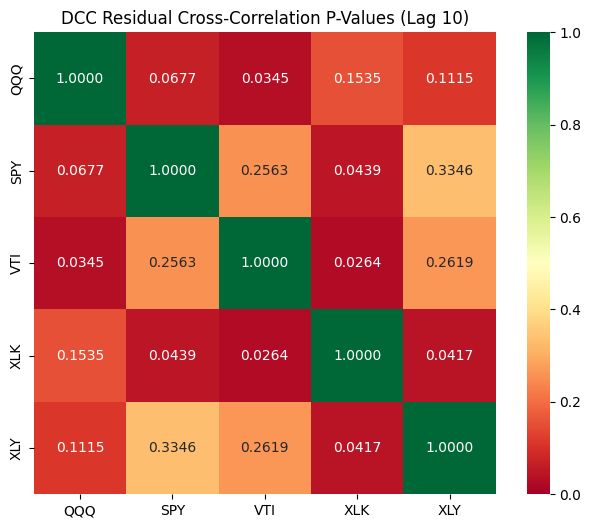


=== Average Correlation Matrix ===


Ticker,QQQ,SPY,VTI,XLK,XLY
Ticker,,,,,
QQQ,0.9998,0.8973,0.8975,0.9534,0.8259
SPY,0.8973,0.9998,0.9878,0.8849,0.8716
VTI,0.8975,0.9878,0.9998,0.8833,0.8803
XLK,0.9534,0.8849,0.8833,0.9998,0.7797
XLY,0.8259,0.8716,0.8803,0.7797,0.9998


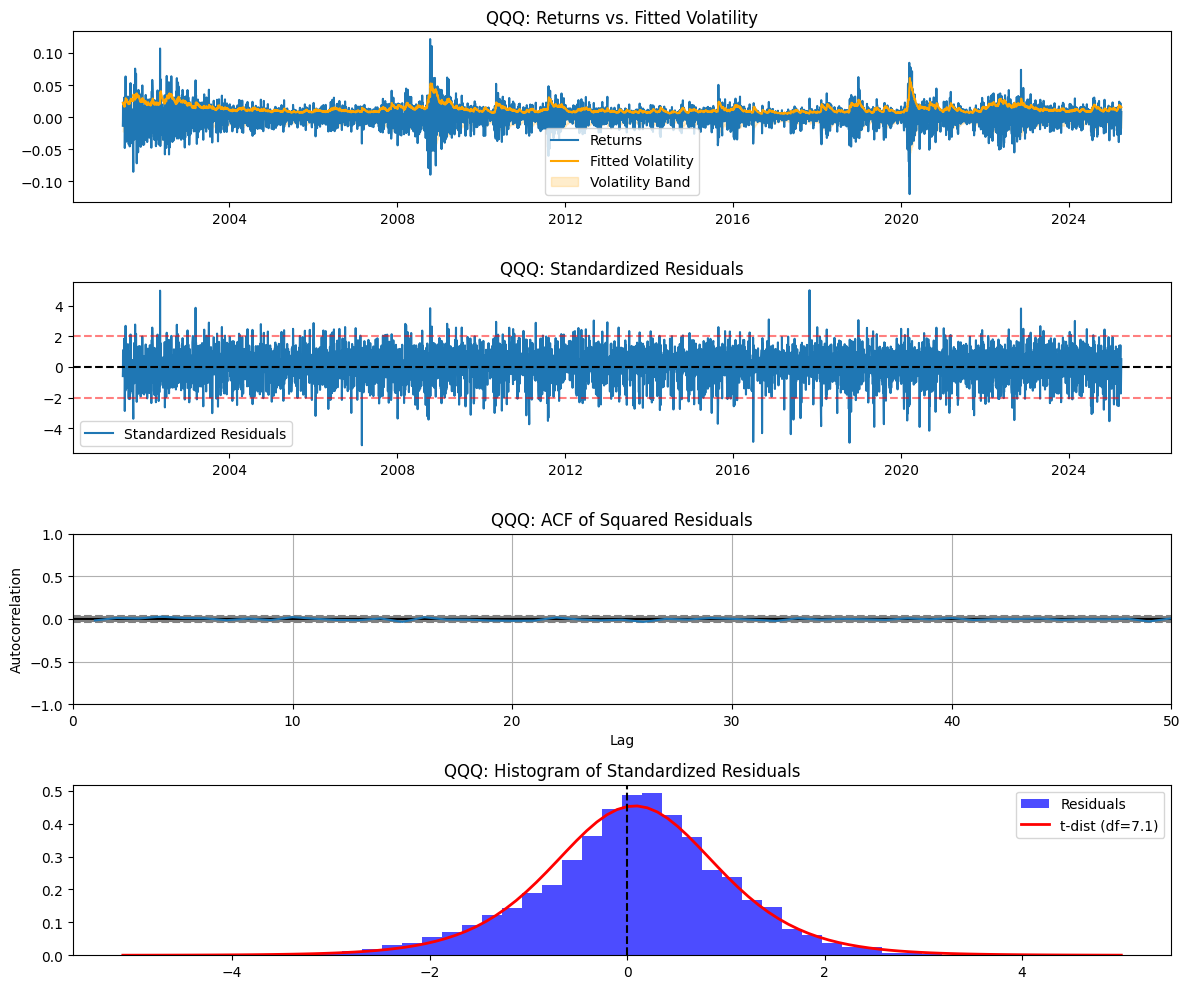

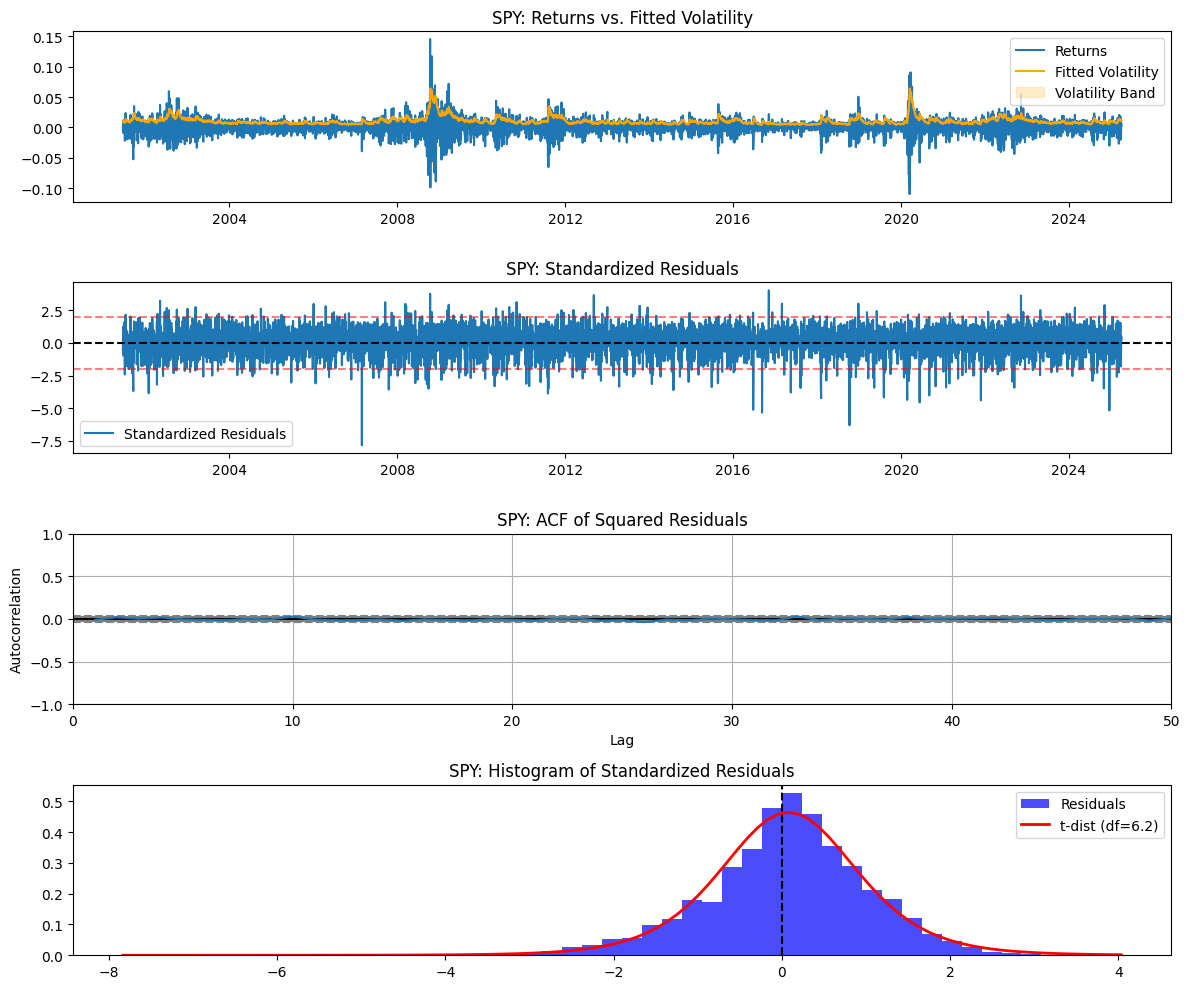

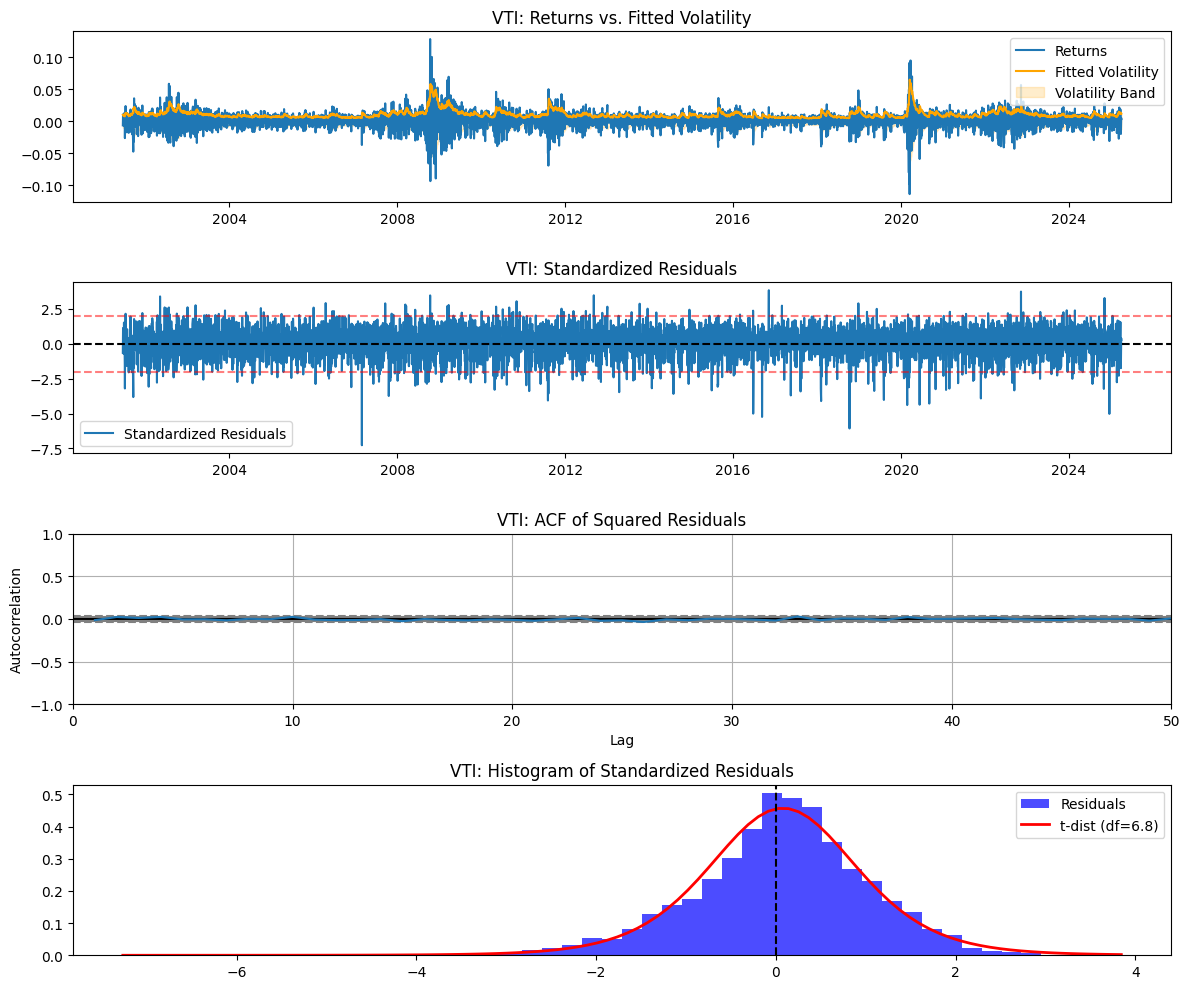

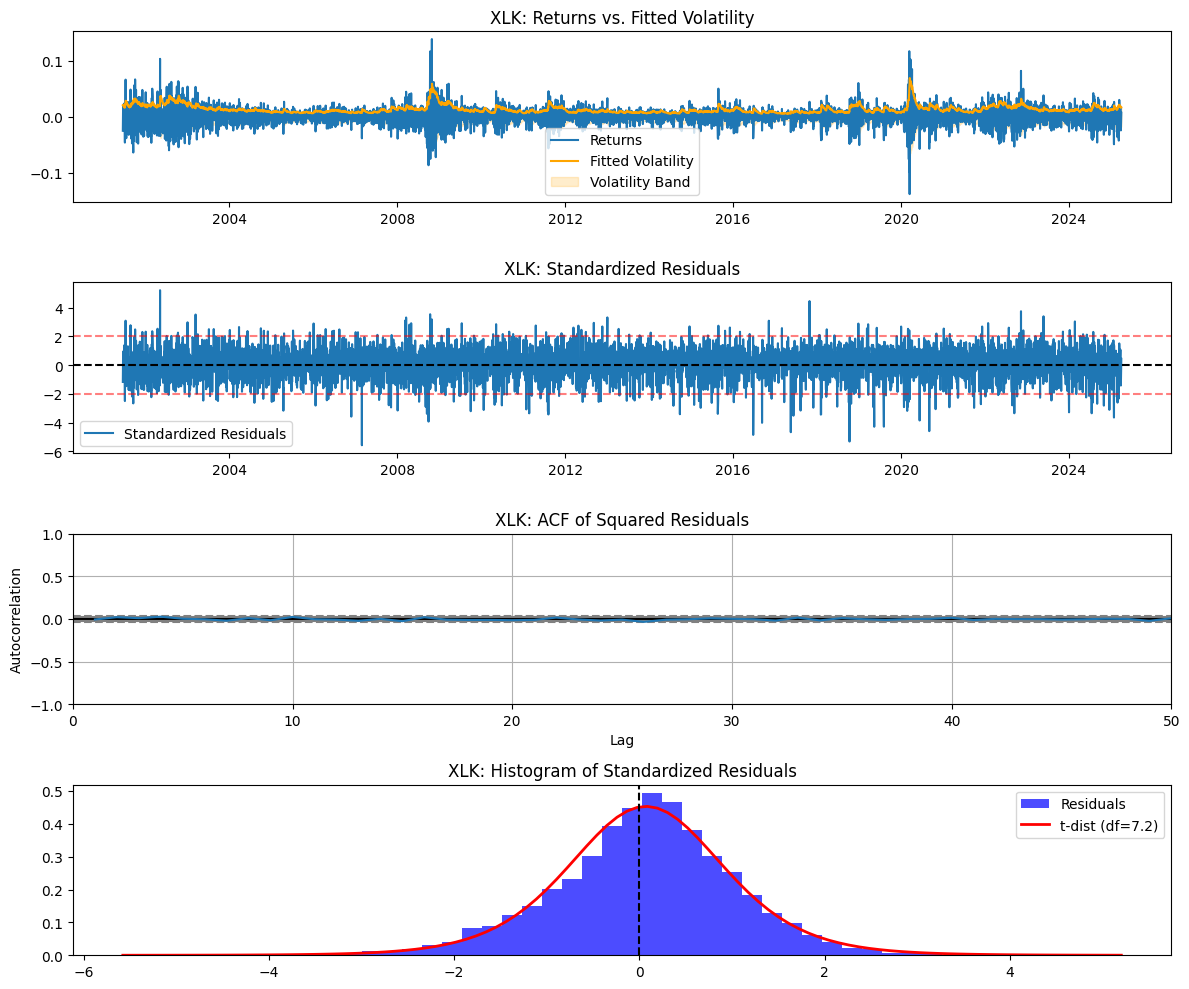

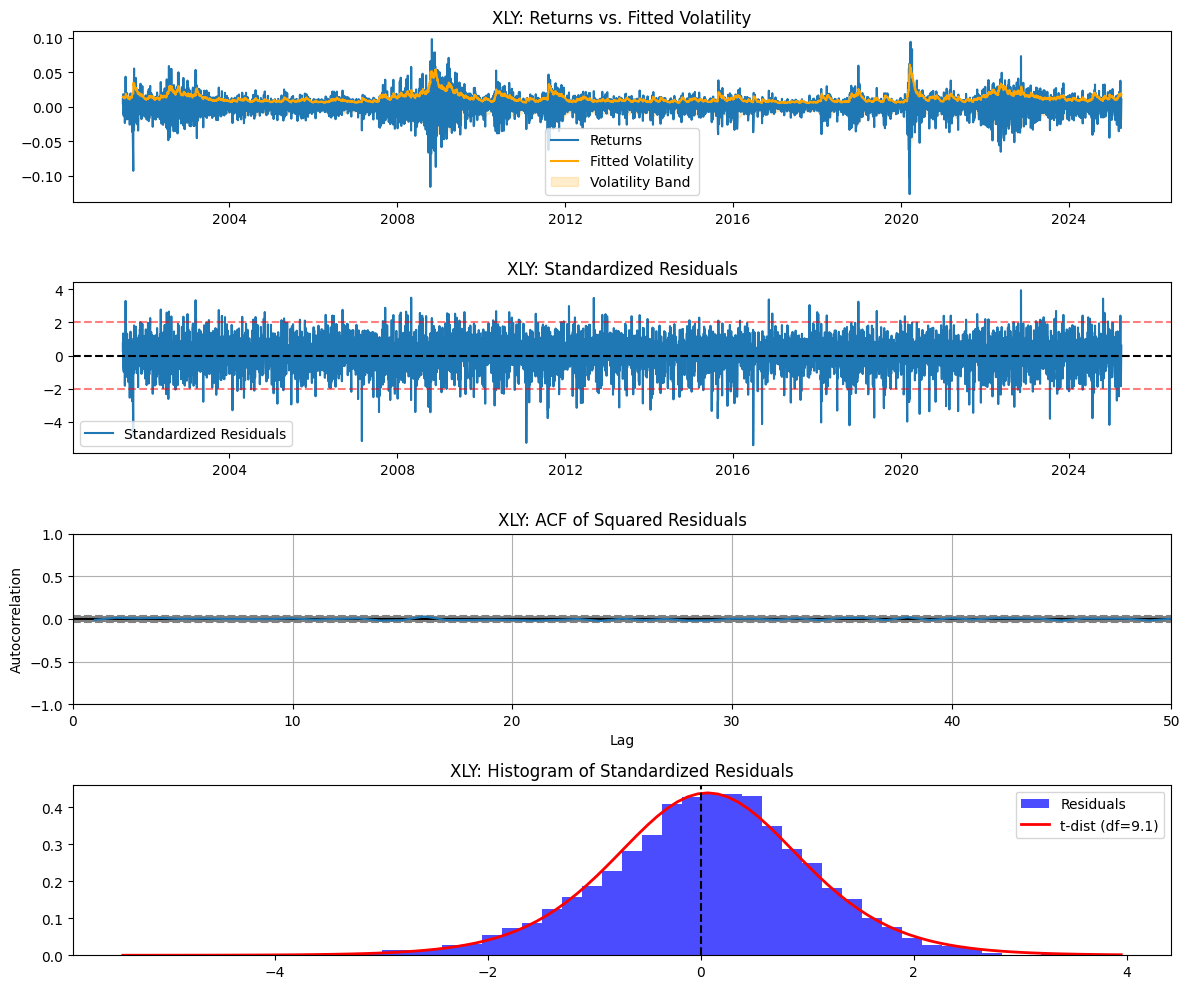

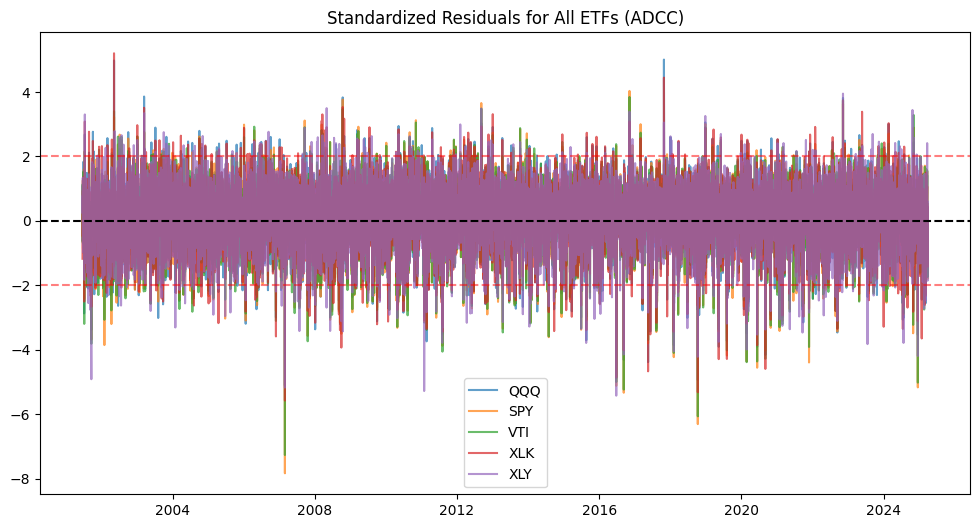

In [6]:
# Example usage

# Fit the model and time it
print("Starting DCC-GARCH fitting...")
start_time = time.time()
dcc_garch = DCC_GARCH(returns)
dcc_garch.fit()
end_time = time.time()

print(f"DCC-GARCH fitting completed in {end_time - start_time:.2f} seconds.")


# Run diagnostics
dcc_garch.diagnostics()
for i in range(len(etf_tickers)):
    dcc_garch.plot_diagnostics(ticker_idx=i)
dcc_garch.plot_all_residuals()

# Display results
vols = dcc_garch.get_volatilities()
# print("Volatility Summary:")
# print(vols.describe())
corrs = dcc_garch.get_correlations()
# print("\nLast day's volatilities:")
# display(vols.iloc[-1])
# print("\nLast day's correlation matrix:")
# display(corrs[-1])